# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [2]:
# relevant imports
import os
from torch import nn, optim
from torchsummary import summary
from datasets import load_dataset
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from ray.train import Checkpoint
from monai.losses import DiceLoss
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from ray.air import session
from pathlib import Path
import torch
from monai.metrics import MeanIoU
from monai.transforms import Activations, AsDiscrete

#### Modelarchitecture
![segnet_graph.png](https://production-media.paperswithcode.com/methods/segnet_Vorazx7.png)


In [3]:
class SegNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SegNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = SegNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_2 = SegNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_3 = SegNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_4 = SegNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.bottle_neck_block_1 = SegNet._conv_block(256, 512)
        self.max_pool_5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Decoder Blocks
        self.decoder_block_5 = SegNet._conv_block(512, 256)

        self.unpool_block_4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_4 = SegNet._conv_block(256, 128)

        self.unpool_block_3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_3 = SegNet._conv_block(128, 64)

        self.unpool_block_2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_2 = SegNet._conv_block(64, 32)

        self.unpool_block_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_1 = SegNet._conv_block(32, 32)

        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e1_1, i1 = self.max_pool_1(e1)

        e2 = self.encoder_block_2(e1_1)
        e2_1, i2 = self.max_pool_2(e2)

        e3 = self.encoder_block_3(e2_1)
        e3_1, i3 = self.max_pool_3(e3)

        e4 = self.encoder_block_4(e3_1)
        e4_1, i4 = self.max_pool_4(e4)

        b = self.bottle_neck_block_1(e4_1)
        b, i5 = self.max_pool_5(b)
        b_unpool = self.max_unpool(b, i5)
        b = self.decoder_block_5(b_unpool)

        d4 = self.unpool_block_4(b, i4)
        d4 = self.decoder_block_4(d4)

        d3 = self.unpool_block_3(d4, i3)
        d3 = self.decoder_block_3(d3)

        d2 = self.unpool_block_2(d3, i2)
        d2 = self.decoder_block_2(d2)

        d1 = self.unpool_block_1(d2, i1)
        d1 = self.decoder_block_1(d1)

        return self.fc(d1)


    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

In [36]:
segnet = SegNet(3, 1)
segnet.cuda()
summary(segnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14  [[

---

#### Datapreparation

In [4]:
isic18_dataset = load_dataset("surajbijjahalli/ISIC2018")
isic18_dataset

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [5]:
class ISICDataset(Dataset):
    def __init__(self, dataset, transform_image=None, transform_mask=None):
        self.dataset = dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image = example['image']
        mask = example['label']
        mask = mask.convert('L')
        mask = np.array(mask)
        mask[mask > 0] = 255
        mask[mask == 0] = 0
        mask = Image.fromarray(mask)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [6]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()])

isic18_train_dataset = ISICDataset(isic18_dataset['train'].select(range(100)), transform_image, transform_mask)
isic18_val_dataset = ISICDataset(isic18_dataset['validation'], transform_image, transform_mask)
isic18_test_dataset = ISICDataset(isic18_dataset['test'], transform_image, transform_mask)

---

#### Training

In [40]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss

In [41]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss

In [42]:
def train_segnet(
        config: dict,
        train_dataset: datasets,
        validation_dataset: datasets,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = SegNet(3, 1).to(device)

    loss_fn = DiceLoss(sigmoid=True)

    optim_params: dict = {
        'lr': config["lr"]
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

    scheduler_params: dict = {
        'gamma': config['gamma'],
        'verbose': False
    }
    scheduler: ExponentialLR = ExponentialLR(optimizer, **scheduler_params)

    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Training with parameter

In [58]:
config = {'lr': 0.0011075820407299578, 'gamma': 0.9596539000640568}

res = train_segnet(config, isic18_train_dataset, isic18_val_dataset, 50, return_flag=True, apply_scheduler=True)

cuda:1
Start training...


  0%|          | 0/50 [00:00<?, ?it/s]

Start:  0
0  -  tr_loss: 0.6737657785415649 val_loss: 0.6985524594783783


  2%|▏         | 1/50 [00:10<08:53, 10.90s/it]

Start:  1
1  -  tr_loss: 0.6523847579956055 val_loss: 0.6987696588039398


  4%|▍         | 2/50 [00:21<08:25, 10.53s/it]

Start:  2
2  -  tr_loss: 0.6452270150184631 val_loss: 0.699448436498642


  6%|▌         | 3/50 [00:31<08:06, 10.36s/it]

Start:  3
3  -  tr_loss: 0.6125338971614838 val_loss: 0.7014745473861694


  8%|▊         | 4/50 [00:41<07:55, 10.33s/it]

Start:  4
4  -  tr_loss: 0.5460845828056335 val_loss: 0.7049151062965393


 10%|█         | 5/50 [00:51<07:44, 10.32s/it]

Start:  5
5  -  tr_loss: 0.4917189031839371 val_loss: 0.7073076665401459


 12%|█▏        | 6/50 [01:02<07:31, 10.25s/it]

Start:  6
6  -  tr_loss: 0.4656590670347214 val_loss: 0.702865332365036


 14%|█▍        | 7/50 [01:12<07:19, 10.22s/it]

Start:  7
7  -  tr_loss: 0.4632362574338913 val_loss: 0.6789548099040985


 16%|█▌        | 8/50 [01:22<07:14, 10.36s/it]

Start:  8
8  -  tr_loss: 0.43362684547901154 val_loss: 0.6405681371688843


 18%|█▊        | 9/50 [01:33<07:08, 10.45s/it]

Start:  9
9  -  tr_loss: 0.4284062087535858 val_loss: 0.604096382856369


 20%|██        | 10/50 [01:44<07:01, 10.55s/it]

Start:  10
10  -  tr_loss: 0.43553099036216736 val_loss: 0.5790464580059052


 22%|██▏       | 11/50 [01:54<06:52, 10.58s/it]

Start:  11
11  -  tr_loss: 0.4213962256908417 val_loss: 0.5592960715293884


 24%|██▍       | 12/50 [02:05<06:37, 10.47s/it]

Start:  12
12  -  tr_loss: 0.4157777726650238 val_loss: 0.5524817407131195


 26%|██▌       | 13/50 [02:15<06:25, 10.43s/it]

Start:  13
13  -  tr_loss: 0.41137439012527466 val_loss: 0.5459994971752167


 28%|██▊       | 14/50 [02:25<06:14, 10.39s/it]

Start:  14
14  -  tr_loss: 0.3998103141784668 val_loss: 0.5434400141239166


 30%|███       | 15/50 [02:36<06:02, 10.36s/it]

Start:  15
15  -  tr_loss: 0.40680594742298126 val_loss: 0.5371181964874268


 32%|███▏      | 16/50 [02:46<05:50, 10.31s/it]

Start:  16
16  -  tr_loss: 0.3922017365694046 val_loss: 0.5315939486026764


 34%|███▍      | 17/50 [02:56<05:40, 10.31s/it]

Start:  17
17  -  tr_loss: 0.3870612531900406 val_loss: 0.5290020704269409


 36%|███▌      | 18/50 [03:06<05:28, 10.26s/it]

Start:  18
18  -  tr_loss: 0.3941827863454819 val_loss: 0.5285901129245758


 38%|███▊      | 19/50 [03:16<05:18, 10.26s/it]

Start:  19
19  -  tr_loss: 0.3960510343313217 val_loss: 0.526597797870636


 40%|████      | 20/50 [03:27<05:07, 10.25s/it]

Start:  20
20  -  tr_loss: 0.39350153505802155 val_loss: 0.5217811465263367


 42%|████▏     | 21/50 [03:37<04:56, 10.22s/it]

Start:  21
21  -  tr_loss: 0.3809567540884018 val_loss: 0.5206250548362732


 44%|████▍     | 22/50 [03:47<04:47, 10.27s/it]

Start:  22
22  -  tr_loss: 0.3781706541776657 val_loss: 0.51741723716259


 46%|████▌     | 23/50 [03:57<04:37, 10.27s/it]

Start:  23
23  -  tr_loss: 0.36981554329395294 val_loss: 0.5161983072757721


 48%|████▊     | 24/50 [04:08<04:27, 10.29s/it]

Start:  24
24  -  tr_loss: 0.3719843477010727 val_loss: 0.517298549413681


 50%|█████     | 25/50 [04:18<04:17, 10.30s/it]

Start:  25
25  -  tr_loss: 0.3690369725227356 val_loss: 0.5117957592010498


 52%|█████▏    | 26/50 [04:28<04:06, 10.28s/it]

Start:  26
26  -  tr_loss: 0.375628337264061 val_loss: 0.5062414705753326


 54%|█████▍    | 27/50 [04:39<03:55, 10.25s/it]

Start:  27
27  -  tr_loss: 0.3642526715993881 val_loss: 0.5071229040622711


 56%|█████▌    | 28/50 [04:49<03:45, 10.24s/it]

Start:  28
28  -  tr_loss: 0.3628292828798294 val_loss: 0.506742462515831


 58%|█████▊    | 29/50 [04:59<03:34, 10.19s/it]

Start:  29
29  -  tr_loss: 0.3708631992340088 val_loss: 0.5052918493747711


 60%|██████    | 30/50 [05:09<03:24, 10.21s/it]

Start:  30
30  -  tr_loss: 0.35646088421344757 val_loss: 0.5001721978187561


 62%|██████▏   | 31/50 [05:19<03:14, 10.25s/it]

Start:  31
31  -  tr_loss: 0.36257731914520264 val_loss: 0.49734723567962646


 64%|██████▍   | 32/50 [05:30<03:04, 10.25s/it]

Start:  32
32  -  tr_loss: 0.3540428578853607 val_loss: 0.4972818195819855


 66%|██████▌   | 33/50 [05:40<02:53, 10.22s/it]

Start:  33
33  -  tr_loss: 0.3540365844964981 val_loss: 0.49921098351478577


 68%|██████▊   | 34/50 [05:50<02:43, 10.24s/it]

Start:  34
34  -  tr_loss: 0.3415848910808563 val_loss: 0.49597635865211487


 70%|███████   | 35/50 [06:00<02:33, 10.20s/it]

Start:  35
35  -  tr_loss: 0.3488849103450775 val_loss: 0.49508070945739746


 72%|███████▏  | 36/50 [06:10<02:22, 10.21s/it]

Start:  36
36  -  tr_loss: 0.34241609275341034 val_loss: 0.49367377161979675


 74%|███████▍  | 37/50 [06:21<02:12, 10.23s/it]

Start:  37
37  -  tr_loss: 0.3487064838409424 val_loss: 0.4930383265018463


 76%|███████▌  | 38/50 [06:31<02:03, 10.25s/it]

Start:  38
38  -  tr_loss: 0.34170450270175934 val_loss: 0.49541546404361725


 78%|███████▊  | 39/50 [06:41<01:52, 10.26s/it]

Start:  39
39  -  tr_loss: 0.3492185026407242 val_loss: 0.4983648210763931


 80%|████████  | 40/50 [06:52<01:43, 10.30s/it]

Start:  40
40  -  tr_loss: 0.34665779769420624 val_loss: 0.49768564105033875


 82%|████████▏ | 41/50 [07:02<01:32, 10.28s/it]

Start:  41
41  -  tr_loss: 0.33009712398052216 val_loss: 0.4963810443878174


 84%|████████▍ | 42/50 [07:12<01:22, 10.28s/it]

Start:  42
42  -  tr_loss: 0.33647167682647705 val_loss: 0.4965166002511978


 86%|████████▌ | 43/50 [07:22<01:11, 10.25s/it]

Start:  43
43  -  tr_loss: 0.33884817361831665 val_loss: 0.4950658977031708


 88%|████████▊ | 44/50 [07:33<01:01, 10.30s/it]

Start:  44
44  -  tr_loss: 0.34001757204532623 val_loss: 0.49629083275794983


 90%|█████████ | 45/50 [07:43<00:51, 10.28s/it]

Start:  45
45  -  tr_loss: 0.33004406094551086 val_loss: 0.4944848120212555


 92%|█████████▏| 46/50 [07:53<00:41, 10.30s/it]

Start:  46
46  -  tr_loss: 0.3321112245321274 val_loss: 0.4926629513502121


 94%|█████████▍| 47/50 [08:04<00:30, 10.25s/it]

Start:  47
47  -  tr_loss: 0.33066390454769135 val_loss: 0.4929421544075012


 96%|█████████▌| 48/50 [08:14<00:20, 10.23s/it]

Start:  48
48  -  tr_loss: 0.33570200204849243 val_loss: 0.4971515089273453


 98%|█████████▊| 49/50 [08:24<00:10, 10.22s/it]

Start:  49
49  -  tr_loss: 0.33243362605571747 val_loss: 0.4969947934150696


100%|██████████| 50/50 [08:34<00:00, 10.30s/it]


In [59]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

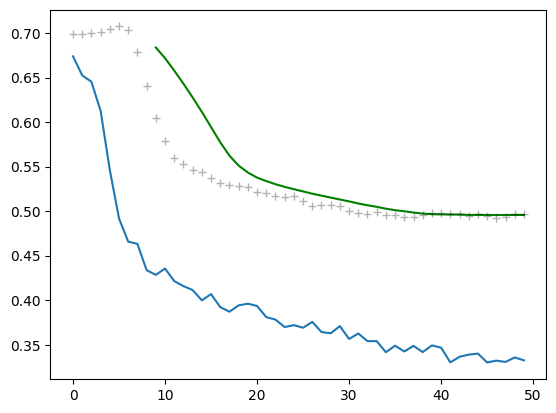

In [60]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [61]:
torch.save(model, '../../res/checkpoints/segnet_isic18_500_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/segnet_isic18_100.pt')

In [9]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [10]:
test_dataloader = DataLoader(isic18_test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
net = SegNet(3, 1).to(device)

net = load_checkpoint(Path('../../res/checkpoints/segnet_isic18_500.pt'), net)

In [11]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy for binary segmentation.
    :param model: neural network
    :param data_loader: torch Dataloader
    :param device: device on which to perform the evaluation
    :return: None
    """
    total_correct_pixels = 0
    total_pixels = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).cpu().numpy()

            targets = targets.numpy().flatten()
            preds = preds.flatten()

            correct_pixels = np.sum(preds == targets)
            total_pixels += targets.size
            total_correct_pixels += correct_pixels

    pixel_accuracy = total_correct_pixels / total_pixels
    print('Pixel Accuracy: ', pixel_accuracy)

In [12]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 16/16 [01:55<00:00,  7.22s/it]

Pixel Accuracy:  0.7233875122070312


In [13]:
def evaluate_binary_mean_iou(model, dataloader, device) -> float:
    """
    Evaluate the Mean IoU for binary segmentation.
    :param model: neural network
    :param dataloader: Torch Dataloader
    :param device: device on which to perform the evaluation
    :return: mean IoU
    """
    mean_iou_metric = MeanIoU(include_background=True, reduction="mean")
    activation = Activations(sigmoid=True)
    discretize = AsDiscrete(threshold=0.5)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            preds = activation(outputs)
            preds = discretize(preds)

            mean_iou_metric(y_pred=preds, y=targets)

    mean_iou = mean_iou_metric.aggregate().item()
    print(f"Mean IoU: {mean_iou}")
    return mean_iou


In [14]:
evaluate_binary_mean_iou(net, test_dataloader, device)

100%|██████████| 16/16 [01:50<00:00,  6.93s/it]

Mean IoU: 0.5121254324913025


0.5121254324913025